In [1]:
### Importing Libraries

import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt

import os
from PIL import Image
from pathlib import Path
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
import keras

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [10]:
songname = f'./genres/blues/blues.00000.au'
y, sr = librosa.load(songname, mono=True, duration=5)
ps = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
ps.shape

(128, 216)

In [11]:
dataset = []
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 
        'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

for genre, index in genres.items():
    for filename in os.listdir(f'./genres/{genre}'):
        songname = f'./genres/{genre}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        ps = librosa.feature.melspectrogram(y=y, sr=sr)
        dataset.append( (ps, index) )               

In [20]:
print(len(dataset))

import random

random.shuffle(dataset)

train = dataset[:700]
valid = dataset[700:850]
test = dataset[850:]

X_train, Y_train = zip(*train)
X_valid, Y_valid = zip(*valid)
X_test, Y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (128, 216, 1) ) for x in X_train])
X_valid = np.array([x.reshape( (128, 216, 1) ) for x in X_valid])
X_test = np.array([x.reshape( (128, 216, 1) ) for x in X_test])

# One-Hot encoding for classes
Y_train = np.array(keras.utils.to_categorical(Y_train, 10))
Y_valid = np.array(keras.utils.to_categorical(Y_valid, 10))
Y_test = np.array(keras.utils.to_categorical(Y_test, 10))

1000


In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import AveragePooling2D

input_shape=(128, 216, 1)
model = Sequential()

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 124, 212, 24)      624       
_________________________________________________________________
average_pooling2d_4 (Average (None, 62, 106, 24)       0         
_________________________________________________________________
activation_6 (Activation)    (None, 62, 106, 24)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 62, 106, 48)       28848     
_________________________________________________________________
average_pooling2d_5 (Average (None, 31, 53, 48)        0         
_________________________________________________________________
activation_7 (Activation)    (None, 31, 53, 48)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 31, 53, 48)       

In [18]:
from keras.callbacks import EarlyStopping

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2)
hist = model.fit(X_train, Y_train, epochs=23, batch_size=32, validation_data= (X_valid, Y_valid))

Train on 700 samples, validate on 150 samples
Epoch 1/23
700/700 [==============================] - 16s 23ms/step - loss: 0.1846 - accuracy: 0.9400 - val_loss: 4.0863 - val_accuracy: 0.4533
Epoch 2/23
700/700 [==============================] - 17s 24ms/step - loss: 0.4338 - accuracy: 0.9143 - val_loss: 2.9202 - val_accuracy: 0.5000
Epoch 3/23
700/700 [==============================] - 18s 26ms/step - loss: 0.2318 - accuracy: 0.9271 - val_loss: 3.1659 - val_accuracy: 0.4667
Epoch 4/23
700/700 [==============================] - 20s 29ms/step - loss: 0.2492 - accuracy: 0.9386 - val_loss: 2.6406 - val_accuracy: 0.4733
Epoch 5/23
700/700 [==============================] - 21s 30ms/step - loss: 0.2183 - accuracy: 0.9300 - val_loss: 2.5828 - val_accuracy: 0.5133
Epoch 6/23
700/700 [==============================] - 21s 29ms/step - loss: 0.1920 - accuracy: 0.9371 - val_loss: 2.8268 - val_accuracy: 0.4867
Epoch 7/23
700/700 [==============================] - 20s 28ms/step - loss: 0.1809 - accur

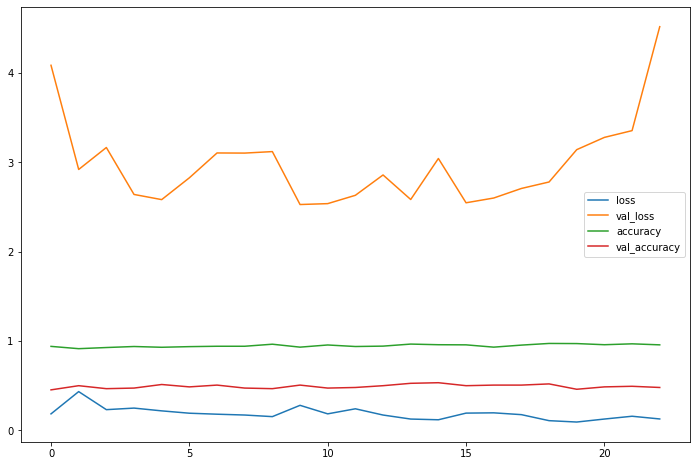

150/150 [==============================] - 1s 7ms/step
Test loss: 4.972743746439616
Test accuracy: 0.4933333396911621


In [19]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','val_loss', 'accuracy','val_accuracy'])
plt.show()

score = model.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])